In [1]:
import numpy as np
import pandas as pd
import queries
import query_filters
import player_info
import situation_detection
import matplotlib.pyplot as plt
import psycopg2

In [2]:
test_bombsite = situation_detection.bombsite_situation(
    filter_obj = query_filters.filter_info(match_id = '1iFV0RYkGIMFnxTpij3oLVmkLYe'))

In [3]:
test_bombsite

bombsite_situation(filter_obj=filter_info(match_id='1iFV0RYkGIMFnxTpij3oLVmkLYe', player=''), map_name='', bombsite_xyz=Empty DataFrame
Columns: []
Index: [], bombsites=[], bomb_frames=[], bomb_events=[])

In [4]:
test_bombsite.find_bombsite_frames()

populate_bombsite_xyz

                    SELECT *
                    FROM public."resultPlayer"
                    WHERE
                        "IsInBombZone" = true
                        AND "matchID" = '1iFV0RYkGIMFnxTpij3oLVmkLYe'
find_bombsite_frames

                    SELECT
                        public."resultPlayer"."Frame" AS "Frame",
                        public."resultPlayer"."RoundNumber" AS "RoundNumber",
                        public."resultPlayer"."CurrentTime" AS "CurrentTime",
                        public."resultPlayer"."Position_X" AS "Position_X",
                        public."resultPlayer"."Position_Y" AS "Position_Y",
                        public."resultPlayer"."Position_Z" AS "Position_Z",
                        public."resultShoot"."Shooter" AS "Shooter",
                        public."resultShoot"."Weapon" AS "Weapon"
                    FROM
                        public."resultPlayer" INNER JOIN public."resultShoot"
                      

In [5]:
test_bombsite.get_bombsite_events()

In [ ]:
### Grab all the events and make a list of event dataframes

# copy bomb frames
tt = test_bombsite.bomb_frames

# group by the round number
tt = tt.groupby(['RoundNumber'])
# Empty dictionary to store the grouped dataframes separately
d = {}

# Loop through each group
for i,grp in tt:
    # Have a threshold of 1280 frames (10 seconds assuming 128 tick rate), and give it an id to separate out the separate events
    grp['event_id']=(~grp['Frame'].diff().div(1280, fill_value=0).lt(2)).cumsum()
    d.update(dict([('df_' + str(i),grp)]))

# copy the empty dataframe into "events"
events = d['df_2'][0:0]
events_last = d['df_2'][0:0]
# Group the dataframes by event id and get the first row (the starting frame of the event)
for grp in d:
    group = d[grp].groupby('event_id')
    events = events.append(group.first())
    events_last = events_last.append(group.last())

# delete the event_id column we don't need it anymore and do some cleanup
del events['event_id']
del events_last['event_id']
events.reset_index(drop=True, inplace=True)
events_last.reset_index(drop=True, inplace=True)

# Get 5 seconds before and store in column
events['Start_Event_Frame'] = events['Frame']-(128*5)

# Create DB connection
connection = psycopg2.connect(user = "postgres",
                                  password = "goodgame",
                                  host = "demos.cdeosts5l1qu.us-east-2.rds.amazonaws.com",
                                  port = "5432",
                                  database = "postgres")

# Prepare empty array to contain our event dataframes
list_event_dataframes = []
# loop through and get the start and end frames, and then make a query to grab the data
for index, row in events.iterrows():
    # Start and end frame
    start_frame = row['Start_Event_Frame']
    end_frame = row['Frame']
    # Make the query
    query = 'SELECT * FROM public."resultPlayer" WHERE public."resultPlayer"."Frame" BETWEEN '+str(start_frame)+' AND '+str(end_frame) + ' ORDER BY "Frame", "Name"'
    # Execute the query
    result = pd.read_sql_query(query, connection)
    # Append results
    list_event_dataframes.append(result)
    
list_event_dataframes

In [6]:
site1_x = (test_bombsite.bombsites[0][0][0],
           test_bombsite.bombsites[0][0][0],
           test_bombsite.bombsites[0][0][1],
           test_bombsite.bombsites[0][0][1],
           test_bombsite.bombsites[0][0][0])

site1_y = (test_bombsite.bombsites[0][1][0],
           test_bombsite.bombsites[0][1][1],
           test_bombsite.bombsites[0][1][1],
           test_bombsite.bombsites[0][1][0],
           test_bombsite.bombsites[0][1][0])

site2_x = (test_bombsite.bombsites[1][0][0],
           test_bombsite.bombsites[1][0][0],
           test_bombsite.bombsites[1][0][1],
           test_bombsite.bombsites[1][0][1],
           test_bombsite.bombsites[1][0][0])

site2_y = (test_bombsite.bombsites[1][1][0],
           test_bombsite.bombsites[1][1][1],
           test_bombsite.bombsites[1][1][1],
           test_bombsite.bombsites[1][1][0],
           test_bombsite.bombsites[1][1][0])

frame_width = 100

site1_min_X = test_bombsite.bombsites[0][0][0] - frame_width
site1_max_X = test_bombsite.bombsites[0][0][1] + frame_width
site1_min_Y = test_bombsite.bombsites[0][1][0] - frame_width
site1_max_Y = test_bombsite.bombsites[0][1][1] + frame_width

site2_min_X = test_bombsite.bombsites[1][0][0] - frame_width
site2_max_X = test_bombsite.bombsites[1][0][1] + frame_width
site2_min_Y = test_bombsite.bombsites[1][1][0] - frame_width
site2_max_Y = test_bombsite.bombsites[1][1][1] + frame_width

box1_x = (site1_min_X, site1_min_X, site1_max_X, site1_max_X, site1_min_X)
box1_y = (site1_min_Y, site1_max_Y, site1_max_Y, site1_min_Y, site1_min_Y)
box2_x = (site2_min_X, site2_min_X, site2_max_X, site2_max_X, site2_min_X)
box2_y = (site2_min_Y, site2_max_Y, site2_max_Y, site2_min_Y, site2_min_Y)

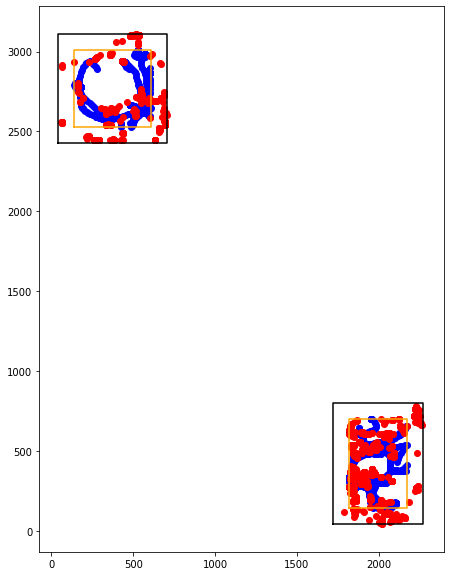

In [7]:
plt.figure(figsize=(max(test_bombsite.bombsite_xyz['Position_X'] / 300),
                    max(test_bombsite.bombsite_xyz['Position_Y'] / 300)))

# approximate box of bombsite
plt.plot(site1_x, site1_y, color='orange')
plt.plot(site2_x, site2_y, color='orange')

# approximate box considered to be shooting around bombsite
plt.plot(box1_x, box1_y, color='black')
plt.plot(box2_x, box2_y, color='black')

# all locations of players inide bombsite
plt.scatter(test_bombsite.bombsite_xyz['Position_X'],
            test_bombsite.bombsite_xyz['Position_Y'], color='blue')

# all location of players shooting inside box around bombsite
plt.scatter(test_bombsite.bomb_frames['Position_X'],
            test_bombsite.bomb_frames['Position_Y'], color='red')

In [10]:
test_bombsite.bomb_events[i][0]

,matchID,Frame,RoundNumber,CurrentTime,Name,SteamID,Position_X,Position_Y,Position_Z,Velocity_X,...,IsPlanting,IsReloading,HasDefuseKit,HasHelmet,Kills,Deaths,Assists,Score,MVPs,CashSpentThisRound
0,1iFV0RYkGIMFnxTpij3oLVmkLYe,49940,2,391.570312,apEX,76561197989744167,975.978333,434.031250,89.645844,0.000000,...,False,False,False,True,1,0,0,2,0,3250
1,1iFV0RYkGIMFnxTpij3oLVmkLYe,49940,2,391.570312,Boombl4,76561198146207066,1569.431885,1114.517090,160.175140,-107.200974,...,False,False,False,False,0,1,0,0,0,1950
2,1iFV0RYkGIMFnxTpij3oLVmkLYe,49940,2,391.570312,electronic,76561198044045107,2127.001465,-147.010193,256.031250,0.000000,...,False,False,False,True,0,1,0,0,0,2000
3,1iFV0RYkGIMFnxTpij3oLVmkLYe,49940,2,391.570312,flamie,76561198116523276,517.353149,3107.826660,206.031250,0.000000,...,False,False,False,False,0,1,0,0,0,1850
4,1iFV0RYkGIMFnxTpij3oLVmkLYe,49940,2,391.570312,misutaaa,76561198081528911,1210.562134,-98.807320,256.031250,-28.662458,...,False,False,False,True,1,0,0,2,0,2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1iFV0RYkGIMFnxTpij3oLVmkLYe,50570,2,396.492188,Perfecto,76561198121220486,1086.119019,2781.997559,128.023804,0.000000,...,False,False,False,True,0,1,0,0,0,2000
636,1iFV0RYkGIMFnxTpij3oLVmkLYe,50570,2,396.492188,RpK,76561198014251501,726.013855,356.080505,96.031250,0.000000,...,False,False,False,True,0,0,0,0,0,3350
637,1iFV0RYkGIMFnxTpij3oLVmkLYe,50570,2,396.492188,s1mple,76561198034202275,1912.003052,202.000137,160.031250,0.000000,...,False,False,False,True,0,1,0,0,0,2000
638,1iFV0RYkGIMFnxTpij3oLVmkLYe,50570,2,396.492188,shox,76561198006920295,936.223755,-606.114746,128.031250,95.436569,...,False,False,False,True,1,0,0,4,0,3600


In [11]:
test_bombsite.bomb_events[i][1]

,matchID,Frame,RoundNumber,CurrentTime,Name,SteamID,Position_X,Position_Y,Position_Z,Velocity_X,...,IsPlanting,IsReloading,HasDefuseKit,HasHelmet,Kills,Deaths,Assists,Score,MVPs,CashSpentThisRound
0,1iFV0RYkGIMFnxTpij3oLVmkLYe,50579,2,396.570312,apEX,76561197989744167,379.514465,584.592712,84.711845,-232.347733,...,False,False,False,True,1,0,0,2,0,3250
1,1iFV0RYkGIMFnxTpij3oLVmkLYe,50579,2,396.570312,Boombl4,76561198146207066,1612.421143,1185.822388,161.869324,79.231422,...,False,False,False,False,0,1,0,0,0,1950
2,1iFV0RYkGIMFnxTpij3oLVmkLYe,50579,2,396.570312,electronic,76561198044045107,2127.001465,-147.010193,256.031250,0.000000,...,False,False,False,True,0,1,0,0,0,2000
3,1iFV0RYkGIMFnxTpij3oLVmkLYe,50579,2,396.570312,flamie,76561198116523276,429.579651,3068.514160,160.031250,65.560539,...,False,False,False,False,0,1,0,0,0,1850
4,1iFV0RYkGIMFnxTpij3oLVmkLYe,50579,2,396.570312,misutaaa,76561198081528911,1204.626709,-256.028748,256.031250,6.120322,...,False,False,False,True,1,0,0,2,0,2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8685,1iFV0RYkGIMFnxTpij3oLVmkLYe,57923,2,453.976562,Perfecto,76561198121220486,977.582336,3207.503174,128.031250,61.866116,...,False,False,False,True,0,1,0,0,0,2000
8686,1iFV0RYkGIMFnxTpij3oLVmkLYe,57923,2,453.976562,RpK,76561198014251501,1853.973755,200.458908,222.031250,68.504852,...,False,False,False,True,0,0,0,0,0,3350
8687,1iFV0RYkGIMFnxTpij3oLVmkLYe,57923,2,453.976562,s1mple,76561198034202275,36.263184,2602.102051,160.031250,0.000000,...,False,False,False,False,0,2,0,0,0,2000
8688,1iFV0RYkGIMFnxTpij3oLVmkLYe,57923,2,453.976562,shox,76561198006920295,-555.254150,112.702499,184.031250,72.747536,...,False,False,False,True,2,0,0,6,0,3600


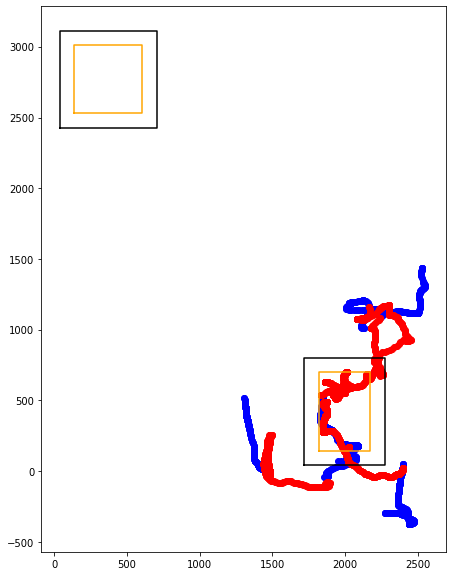

In [15]:
plt.figure(figsize=(max(test_bombsite.bombsite_xyz['Position_X'] / 300),
                    max(test_bombsite.bombsite_xyz['Position_Y'] / 300)))

# approximate box of bombsite
plt.plot(site1_x, site1_y, color='orange')
plt.plot(site2_x, site2_y, color='orange')

# approximate box considered to be shooting around bombsite
plt.plot(box1_x, box1_y, color='black')
plt.plot(box2_x, box2_y, color='black')

i = 2

# all locations of players preceding bombsite event
plt.scatter(test_bombsite.bomb_events[i][0]['Position_X'],
            test_bombsite.bomb_events[i][0]['Position_Y'], color='blue')

# all location of players during bombsite event
plt.scatter(test_bombsite.bomb_events[i][1]['Position_X'],
            test_bombsite.bomb_events[i][1]['Position_Y'], color='red')

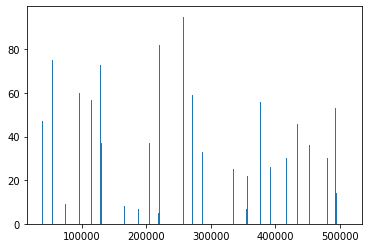

In [27]:
# x is the frame number, as expected, bombsite engagements are pretty discrete
p = plt.hist(test_bombsite.bombsite_xyz['Frame'], bins = 500)

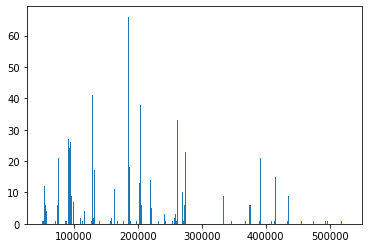

In [28]:
p = plt.hist(test_bombsite.bomb_frames['Frame'], bins = 500)

In [16]:
tt = test_bombsite.bombsite_xyz[test_bombsite.bombsite_xyz['RoundNumber']==2]

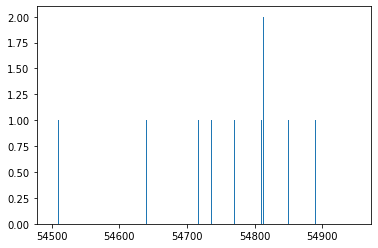

In [22]:
p = plt.hist(tt['Frame'], bins = 2500)